In [11]:
import os
import json
import numpy as np
import cv2
from pathlib import Path

NB_DIR = Path().resolve()
ROOT = NB_DIR.parent # project root

print("Notebook directory:", NB_DIR)
print("ROOT:", ROOT)

IMG_DIR = ROOT / "data/images2"
ANN_DIR = ROOT / "data/arrow_data/arrow_annotations"
OUT_IMG_DIR = ROOT / "data/arrow_data/images_out"
OUT_HM_DIR = ROOT / "data/arrow_data/heatmaps"

os.makedirs(OUT_IMG_DIR, exist_ok=True)
os.makedirs(OUT_HM_DIR, exist_ok=True)

# scaling factor for ALL images
SCALE = 0.25       # training resolution scaling
SIGMA = 6          # gaussian size

Notebook directory: /Users/jleto/LocalProjects/rev_vision/notebooks
ROOT: /Users/jleto/LocalProjects/rev_vision


In [10]:
# Converts LabelMe point annotations into resized training images and
# per-arrow Gaussian heatmaps (left, middle, right) saved as .npy files.

# generate a 2D Gaussian centered at (cx, cy)
def gaussian_heatmap(h, w, cx, cy, sigma):
    X, Y = np.meshgrid(np.arange(w), np.arange(h))
    return np.exp(-((X - cx)**2 + (Y - cy)**2) / (2 * sigma**2))

# iterate through each json file
for file in os.listdir(ANN_DIR):
    if not file.endswith(".json"):
        continue

    # load annotation json
    json_path = os.path.join(ANN_DIR, file)
    with open(json_path, "r") as f:
        data = json.load(f)

    # load the corresponding image filename stored in the annotation
    img_filename = os.path.basename(data["imagePath"]) 
    img_path = os.path.join(IMG_DIR, img_filename)

    # skip if image is missing
    if not os.path.exists(img_path):
        print("Missing image:", img_path) 
        continue

    # load original image
    img = cv2.imread(img_path)
    H, W = img.shape[:2]

    # compute scaled dimensions
    new_w = int(W * SCALE)
    new_h = int(H * SCALE)

    # resize image
    img_resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    cv2.imwrite(os.path.join(OUT_IMG_DIR, img_filename), img_resized)
    print("Saved:", img_filename)

    # allocate heatmaps
    hm_left   = np.zeros((new_h, new_w), dtype=np.float32)
    hm_center = np.zeros((new_h, new_w), dtype=np.float32)
    hm_right  = np.zeros((new_h, new_w), dtype=np.float32)

    # create heatmaps
    for shape in data["shapes"]:
        label = shape["label"]
        x, y = shape["points"][0]

        # scale annotation coordinates
        sx = x * SCALE
        sy = y * SCALE

        if label == "left":
            hm_left += gaussian_heatmap(new_h, new_w, sx, sy, SIGMA)
        elif label == "middle":
            hm_center += gaussian_heatmap(new_h, new_w, sx, sy, SIGMA)
        elif label == "right":
            hm_right += gaussian_heatmap(new_h, new_w, sx, sy, SIGMA)

    # stack into (H,W,3)
    heatmap = np.stack([hm_left, hm_center, hm_right], axis=-1)

    # normalize per-channel
    heatmap /= heatmap.max(axis=(0,1), keepdims=True) + 1e-8

    # save
    out_name = file.replace(".json", ".npy")
    np.save(os.path.join(OUT_HM_DIR, out_name), heatmap)

    print("Saved:", out_name)

Saved: frame_0007.png
Saved: frame_0007.npy
Saved: frame_0011.png
Saved: frame_0011.npy
Saved: frame_0027.png
Saved: frame_0027.npy
Saved: frame_0026.png
Saved: frame_0026.npy
Saved: frame_0030.png
Saved: frame_0030.npy
Saved: frame_0010.png
Saved: frame_0010.npy
Saved: frame_0006.png
Saved: frame_0006.npy
Saved: frame_0021.png
Saved: frame_0021.npy
Saved: frame_0016.png
Saved: frame_0016.npy
Saved: frame_0020.png
Saved: frame_0020.npy
Saved: frame_0023.png
Saved: frame_0023.npy
Saved: frame_0019.png
Saved: frame_0019.npy
Saved: frame_0014.png
Saved: frame_0014.npy
Saved: frame_0018.png
Saved: frame_0018.npy
Saved: frame_0022.png
Saved: frame_0022.npy
Saved: frame_0029.png
Saved: frame_0029.npy
Saved: frame_0013.png
Saved: frame_0013.npy
Saved: frame_0005.png
Saved: frame_0005.npy
Saved: frame_0025.png
Saved: frame_0025.npy
Saved: frame_0009.png
Saved: frame_0009.npy
Saved: frame_0008.png
Saved: frame_0008.npy
Saved: frame_0032.png
Saved: frame_0032.npy
Saved: frame_0024.png
Saved: fra

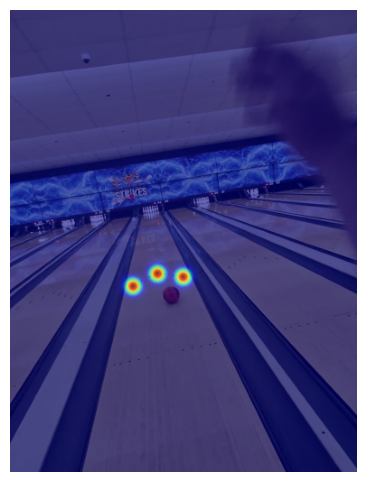

In [ ]:
# Visual sanity-check: overlays a generated heatmap onto its resized image
# to confirm the Gaussian blobs are correctly aligned.

from matplotlib import pyplot as plt

alpha = 0.6 # opacity of the heatmap overlay

# iterate through all saved heatmaps
for hm_file in os.listdir(OUT_HM_DIR):
    if not hm_file.endswith(".npy"):
        continue

    
    heatmap = np.load(os.path.join(OUT_HM_DIR, hm_file)) # load heatmap   

    # find matching resized training image
    img_file = hm_file.replace(".npy", ".png")
    img_path = os.path.join(OUT_IMG_DIR, img_file)

    # skip if image missing
    if not os.path.exists(img_path):
        print("Missing:", img_file)
        continue

    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) # load img and convert it to RBG for matplotlib

    combined = heatmap.max(axis=2) 
    combined = (combined * 255).astype(np.uint8)
    colored = cv2.applyColorMap(combined, cv2.COLORMAP_JET)
    colored = cv2.cvtColor(colored, cv2.COLOR_BGR2RGB)
    overlay = (img * (1 - alpha) + colored * alpha).astype(np.uint8)

    # show result using matplotlib
    plt.figure(figsize=(8,6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()

    break  # show only the first example

Dataset size: 25
Image shape: (512, 384, 3)
Heatmap shape: (512, 384, 3)


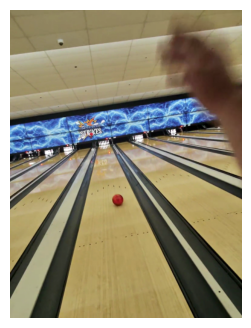

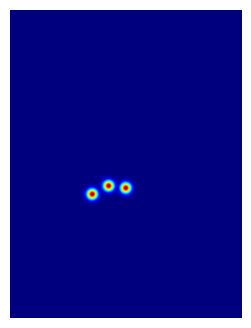

In [ ]:
# Dataset sanity check: verifies matching image/heatmap files, checks shapes, and shows a visual sample.

from models.arrow_regression.arrow_dataset import ArrowDataset

ds = ArrowDataset(str(OUT_IMG_DIR), str(OUT_HM_DIR))
print("Dataset size:", len(ds))

if len(ds) > 0:
    img, hm = ds[0]
    print("Image shape:", img.shape)
    print("Heatmap shape:", hm.shape)

    from matplotlib import pyplot as plt

    overlay = (img * 255).astype(np.uint8)
    hm_vis = (hm.max(axis=-1) * 255).astype(np.uint8)

    plt.figure(figsize=(6,4))
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.imshow(hm_vis, cmap="jet")
    plt.axis("off")
    plt.show()